In [76]:
import pandas as pd
from pandas.core.common import SettingWithCopyWarning

import warnings
warnings.filterwarnings("ignore")
import json

from datetime import datetime
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import requests

In [77]:
def plot_roc_curve(true_y, y_prob):

    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

В этом блокноте будут лежать эксперименты с моделями. В первую очередь возьмем катбуст из ноутбука с EDA и переберем параметры для улучшения качества.

# Итерация 1

In [78]:
df = pd.read_csv('data.csv', index_col=[0])

In [79]:
df.head(5)

,addr,port,proto,num_timestamps,mean_timestamps,median_timestamps,country,anomaly
0,140.82.121.6,443.0,tcp,25.0,52712.0,4318.0,United States,0
1,172.64.41.4,443.0,tcp,12880.0,45894.0,647.0,United States,0
2,34.160.144.191,443.0,tcp,37.0,746263.0,1422.0,United States,0
3,209.85.233.104,443.0,tcp,899.0,550077.0,336.0,United States,0
4,209.85.233.94,443.0,tcp,493.0,213314.0,2324.0,United States,0


In [80]:
X = df[['addr', 'proto', 'num_timestamps', 'mean_timestamps', 
    'median_timestamps', 'anomaly', 'country']].drop_duplicates()
X = X.fillna(0)

X = X[X['addr'] != '10.4.19.138']
X = X.merge(pd.DataFrame(list(X['addr'].str.split('.').values), columns = ['addr_1',
                                                        'addr_2',
                                                        'addr_3', 
                                                        'addr_4']), left_index=True, right_index=True)

y = X['anomaly']
X = X.drop(['anomaly', 'addr_3', 'addr_4', 'addr'], axis = 1)

from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state = 42, test_size = 0.3)

In [81]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(Xtrain[['num_timestamps', 'mean_timestamps', 'median_timestamps']])

In [82]:
Xtrain = pd.concat([Xtrain[['proto', 'country', 'addr_1', 
                   'addr_2']].reset_index(), pd.DataFrame(scaler.transform(Xtrain[['num_timestamps', 
                   'mean_timestamps', 'median_timestamps']]),
                   columns = ['num_timestamps', 'mean_timestamps', 'median_timestamps'])], axis=1)

In [83]:
Xtrain = Xtrain.drop('index', axis=1)

In [84]:
Xtest = pd.concat([Xtest[['proto', 'country', 'addr_1', 
                   'addr_2']].reset_index(), pd.DataFrame(scaler.transform(Xtest[['num_timestamps', 
                   'mean_timestamps', 'median_timestamps']]),
                   columns = ['num_timestamps', 'mean_timestamps', 'median_timestamps'])], axis=1)

In [85]:
Xtest = Xtest.drop('index', axis=1)

In [86]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV

params = {'depth': [None, 1, 5, 10],
          'learning_rate' : [None, 0.05, 0.1, 0.5],
          'iterations'    : [None, 100, 200]
         }

ctb = CatBoostClassifier(random_state=42, verbose=False,
                        cat_features = ['addr_1', 'addr_2', 'proto', 'country'])

ctb_model = GridSearchCV(ctb, params, scoring="f1", return_train_score=True, cv=3)
ctb_model.fit(Xtrain, ytrain)
print(ctb_model.best_params_)
print(ctb_model.best_score_)

{'depth': 5, 'iterations': 200, 'learning_rate': 0.5}
0.7111560498820357


In [87]:
print(ctb_model.best_params_)
print(ctb_model.best_score_)

{'depth': 5, 'iterations': 200, 'learning_rate': 0.5}
0.7111560498820357


In [88]:
clf = CatBoostClassifier(random_state=42, verbose=False,
                        cat_features = ['addr_1', 'addr_2', 'proto', 'country'],
                        depth= 5, iterations= 200, learning_rate= 0.5)

In [89]:
model = clf.fit(Xtrain, ytrain)

In [90]:
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay

print (f"roc_auc_score на трейне: {round(roc_auc_score(ytrain, model.predict(Xtrain)), 2)}")
print (f"roc_auc_score на тесте: {round(roc_auc_score(ytest, model.predict(Xtest)), 2)}")

roc_auc_score на трейне: 0.96
roc_auc_score на тесте: 0.81


In [91]:
print (f"f1_score на трейне: {round(f1_score(ytrain, model.predict(Xtrain)), 2)}")
print (f"f1_score на тесте: {round(f1_score(ytest, model.predict(Xtest)), 2)}")

f1_score на трейне: 0.96
f1_score на тесте: 0.73


model AUC score: 0.8093459166510932


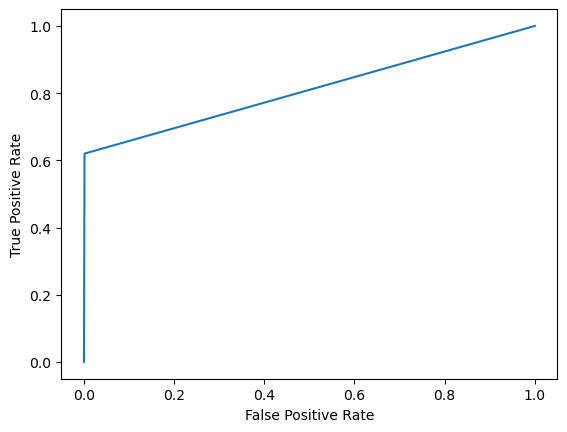

In [92]:
plot_roc_curve(ytest, model.predict(Xtest))
print(f'model AUC score: {roc_auc_score(ytest, model.predict(Xtest))}')

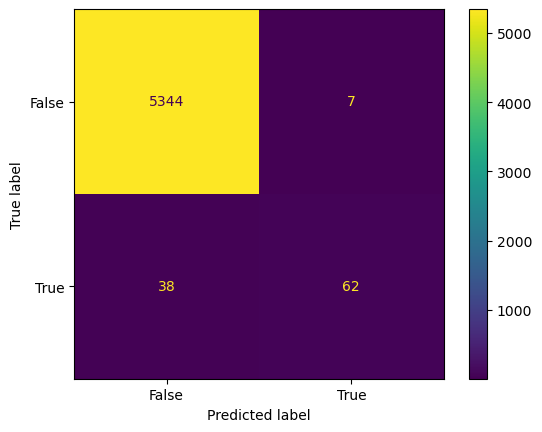

In [93]:
confusion_matrix = confusion_matrix(ytest, model.predict(Xtest))

cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()
# много ошибается на определении аноималии

<function matplotlib.pyplot.show(close=None, block=None)>

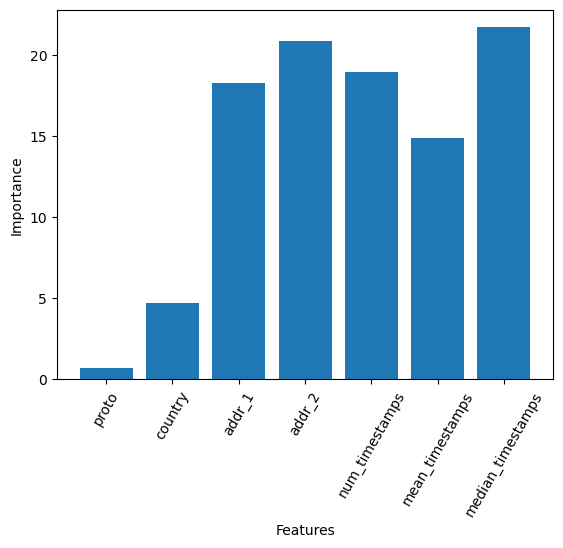

In [94]:
plt.bar(Xtrain.columns, model.feature_importances_)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=60)
plt.show

In [95]:
import pickle
pickle.dump(model, open('ctb_model.pkl', 'wb'))

In [96]:
import joblib

joblib.dump(scaler, 'std_scaler.bin', compress=True)

['std_scaler.bin']

# Итерация 2

In [97]:
X = df[['addr', 'proto', 'num_timestamps', 'mean_timestamps', 
    'median_timestamps', 'anomaly', 'country']].drop_duplicates()
X = X.fillna(0)

X = X[X['addr'] != '10.4.19.138']
X = X.merge(pd.DataFrame(list(X['addr'].str.split('.').values), columns = ['addr_1',
                                                        'addr_2',
                                                        'addr_3', 
                                                        'addr_4']), left_index=True, right_index=True)

X_new = X.drop(['proto', 'country', 'addr_1', 'addr_2'], 
                     axis=1).merge(pd.get_dummies(X[['proto', 'country', 'addr_1', 'addr_2']], drop_first = True),
                                                    left_index = True, right_index=True)

y = X_new['anomaly']
X_new = X_new.drop(['anomaly', 'addr_3', 'addr_4', 'addr'], axis = 1)

from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X_new, y, random_state = 42, test_size = 0.3)

In [98]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(Xtrain)
params = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
    }
rfc = RandomForestClassifier(random_state=42)

rfc_model = GridSearchCV(rfc, params, scoring="f1")
rfc_model.fit(scaler.transform(Xtrain), ytrain)
print(rfc_model.best_params_)
print(rfc_model.best_score_)

{'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 200}
0.16986722571628232


In [99]:
# явно хуже катбуста

# Итерация 3

In [100]:
X = df[['addr', 'proto', 'num_timestamps', 'mean_timestamps', 
    'median_timestamps', 'anomaly', 'country']].drop_duplicates()
X = X.fillna(0)

X = X[X['addr'] != '10.4.19.138']
X = X.merge(pd.DataFrame(list(X['addr'].str.split('.').values), columns = ['addr_1',
                                                        'addr_2',
                                                        'addr_3', 
                                                        'addr_4']), left_index=True, right_index=True)

X_new = X.drop(['proto', 'country', 'addr_1', 'addr_2'], 
                     axis=1).merge(pd.get_dummies(X[['proto', 'country', 'addr_1', 'addr_2']], drop_first = True),
                                                    left_index = True, right_index=True)

y = X_new['anomaly']
X_new = X_new.drop(['anomaly', 'addr_3', 'addr_4', 'addr'], axis = 1)

from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X_new, y, random_state = 42, test_size = 0.3)

In [101]:
from sklearn.linear_model import LogisticRegression

params = {"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}

lr = LogisticRegression(random_state=42)

lr_model = GridSearchCV(lr, params, scoring="f1")
lr_model.fit(scaler.transform(Xtrain), ytrain)
print(lr_model.best_params_)
print(lr_model.best_score_)

{'C': 10.0, 'penalty': 'l2'}
0.5304590786302994


In [102]:
# здесь куда лучше результат

# Итерация 4

In [103]:
X = df[['addr', 'proto', 'num_timestamps', 'mean_timestamps', 
    'median_timestamps', 'anomaly', 'country']].drop_duplicates()
X = X.fillna(0)

X = X[X['addr'] != '10.4.19.138']
X = X.merge(pd.DataFrame(list(X['addr'].str.split('.').values), columns = ['addr_1',
                                                        'addr_2',
                                                        'addr_3', 
                                                        'addr_4']), left_index=True, right_index=True)

X_new = X.drop(['proto', 'country', 'addr_1', 'addr_2'], 
                     axis=1).merge(pd.get_dummies(X[['proto', 'country', 'addr_1', 'addr_2']], drop_first = True),
                                                    left_index = True, right_index=True)

y = X_new['anomaly']
X_new = X_new.drop(['anomaly', 'addr_3', 'addr_4', 'addr'], axis = 1)

from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X_new, y, random_state = 42, test_size = 0.3)

In [104]:
from pyod.models.inne import INNE

params = {'n_estimators': [50,100,200,500],
          'contamination' : [0.01,0.1,0.5,0.5]
         }
inn = INNE(random_state=42)

inn_model = GridSearchCV(inn, params, scoring="f1")
inn_model.fit(scaler.transform(Xtrain), ytrain)
print(inn_model.best_params_)
print(inn_model.best_score_)

{'contamination': 0.1, 'n_estimators': 500}
0.11275395233022727


In [105]:
# здесь совсем слабо

# Итог, 

лучше всего себя показал катбуст. Его и возьмем за основу, будем улучшать.

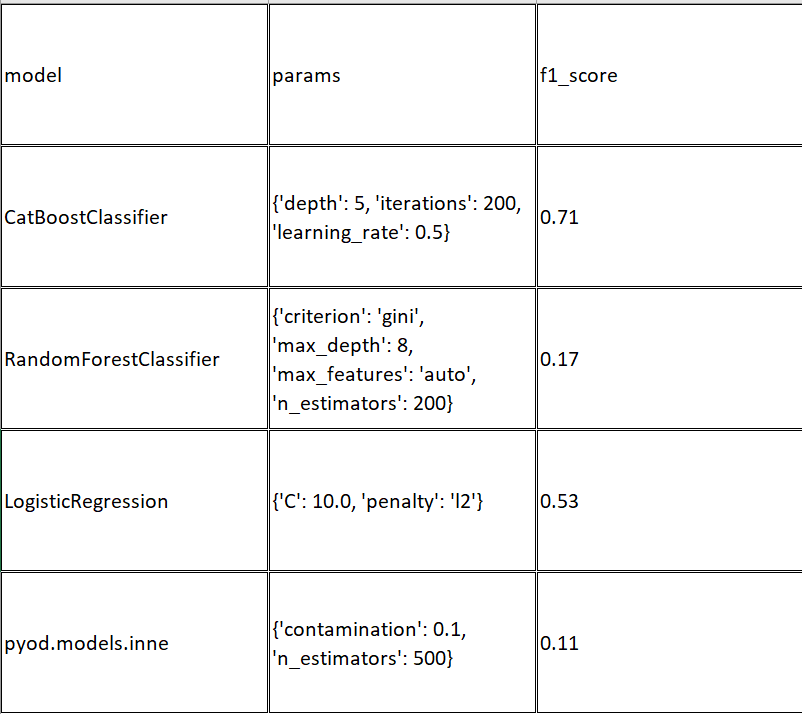